# Importing libraries and cleaned dataset

In [49]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, HDBSCAN

import hdbscan

**Original Dataset**:

Chen,Daqing. (2015). Online Retail. UCI Machine Learning Repository. https://archive.ics.uci.edu/dataset/352/online+retail

In [2]:
# Importing the cleaned dataset from my first notebook
file_path = '../data/data_cleaned.csv'
df = pd.read_csv(file_path, dtype={'InvoiceNo': 'O','StockCode': 'O','Description': 'O',
                                   'Quantity': 'int64','UnitPrice': 'float64',
                                   'CustomerID': 'Int64','Country': 'O'}, parse_dates=['InvoiceDate'])

# Filtering the dataset

Based on the initial analysis conducted in previous notebooks, I have made some preliminary decisions regarding data filtering. These decisions include retaining only sales data from the UK while excluding two outlier cases. Additionally, I am filtering the dataset to include only sales related to products.

In [3]:
# Filtering out the data that are not for products (shipping, bank fees etc)
df = df[df.StockCode != 'OTHER']

# Focusing only on clients from UK (they consist 90% of the clients)
# -> At a later stage I could also check adding Germany and France, to refer then to almost 95% of clients
df = df[df.Country == 'United Kingdom']

# Finally, dropping the null values from CustomerID, since the ML model will be based on the different clients
df.dropna(subset='CustomerID', inplace=True)

# Creating new column with the total price for each item 
df['TotalPrice'] = df.Quantity * df.UnitPrice

# Temporarily removing two outliers identified in 01_InitialExploration for further transformation
# allows continued exploration and visualization until outliers are addressed.
df_fltrd = df[~df.InvoiceNo.isin(['581483','541431'])]

# Feature Engineering

**Total Quantity:** Wholesale customers are likely to purchase larger quantities of items compared to retail customers: using the total quantity purchased by each customer as a feature.

**Total Price:** Wholesale customers typically spend more money on their purchases compared to retail customers: using the total price of orders can help distinguish between the two groups.

**Average Quantity per Item:** Average quantity per item for each customer. Wholesale customers may buy multiples of the same item in a single order, leading to a higher average quantity per item.

**Average Order Value:** The average amount spent per order by each customer. 

[**Frequency of Orders:** Wholesale customers are likely to place orders more frequently than retail customers. To calculate the total number of orders for each customer over a given time period.]

For my ML model I will try clustering algorithms such as K-means, DBSCAN, HDBSCAN, or hierarchical clustering. I will do feature engineering, and conduct an EDA to see my data, and experiment and decide on the best model.

In [4]:
# Notes

# inertia - for clustering K-means
# Silhouette
# error metrics differerent per model

# hdbscan check!

# can i use dbscan together with some transformation? something that is not sensitive too much to outliers?

In [5]:
# note: I am starting to think that for my model, I can spot 1 cluster (majority of clients not wholesale)
# that seem to have more common ordering bahaviour, and what is left the outliers might be my other group
# maybe these outliers if analysed seperataly make sense, just because the two groups have so different scales and characteristics

### Total quantity purchased

In [6]:
cust = df_fltrd.groupby('CustomerID')['Quantity'].sum().reset_index().rename(columns={'Quantity': 'TotalQuantity'})
cust.head()

,CustomerID,TotalQuantity
0,12747,1275
1,12748,25051
2,12749,1470
3,12820,722
4,12821,70


### Total value of orders

In [7]:
cust = pd.merge(cust, df_fltrd.groupby('CustomerID')['TotalPrice'].sum().reset_index().rename(columns={'TotalPrice': 'TotalValue'}), 
                                                                                       how='left', on='CustomerID')
cust.head()

,CustomerID,TotalQuantity,TotalValue
0,12747,1275,4722.51
1,12748,25051,46021.25
2,12749,1470,4043.94
3,12820,722,938.94
4,12821,70,92.72


### Average quantity per item per order

In [8]:
# Grouping by StockCode, in case in the same invoice client has added the product more than once
item_quant = df_fltrd.groupby(['CustomerID','InvoiceNo','StockCode'])['Quantity'].sum().reset_index()

cust = pd.merge(cust, item_quant.groupby('CustomerID')['Quantity'].mean().round(2).reset_index().rename(columns={'Quantity':'AvrgQuantity'}), 
                                                                                       how='left', on='CustomerID')
cust.head()

,CustomerID,TotalQuantity,TotalValue,AvrgQuantity
0,12747,1275,4722.51,12.38
1,12748,25051,46021.25,5.87
2,12749,1470,4043.94,7.42
3,12820,722,938.94,12.24
4,12821,70,92.72,11.67


### Average value per order

In [9]:
# not sure if I will use that

In [10]:
order_val = df_fltrd.groupby(['CustomerID','InvoiceNo'])['TotalPrice'].sum().reset_index()
avrg_val = order_val.groupby('CustomerID')['TotalPrice'].mean().round(2).reset_index().rename(columns={'TotalPrice':'AvrgOrderValue'})

cust = pd.merge(cust, avrg_val, how='left', on='CustomerID')
cust

,CustomerID,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
0,12747,1275,4722.51,12.38,429.32
1,12748,25051,46021.25,5.87,223.40
2,12749,1470,4043.94,7.42,808.79
3,12820,722,938.94,12.24,234.74
4,12821,70,92.72,11.67,92.72
...,...,...,...,...,...
3911,18280,45,180.75,4.50,180.75
3912,18281,54,80.82,7.71,80.82
3913,18282,103,152.61,8.58,76.31
3914,18283,1355,2028.13,1.97,126.76


### Frequency of Orders, total orders number

Not using it for now.

In [11]:
'''
cust = pd.merge(cust, df_fltrd.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'TotalOrders'}), 
                                                                                       how='left', on='CustomerID')
cust.head()
'''

"\ncust = pd.merge(cust, df_fltrd.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().rename(columns={'InvoiceNo': 'TotalOrders'}), \n                                                                                       how='left', on='CustomerID')\ncust.head()\n"

# Setting CustomerID as index

In [12]:
cust.set_index('CustomerID', inplace=True)
cust

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
CustomerID,,,,
12747,1275,4722.51,12.38,429.32
12748,25051,46021.25,5.87,223.40
12749,1470,4043.94,7.42,808.79
12820,722,938.94,12.24,234.74
12821,70,92.72,11.67,92.72
...,...,...,...,...
18280,45,180.75,4.50,180.75
18281,54,80.82,7.71,80.82
18282,103,152.61,8.58,76.31


# EDA

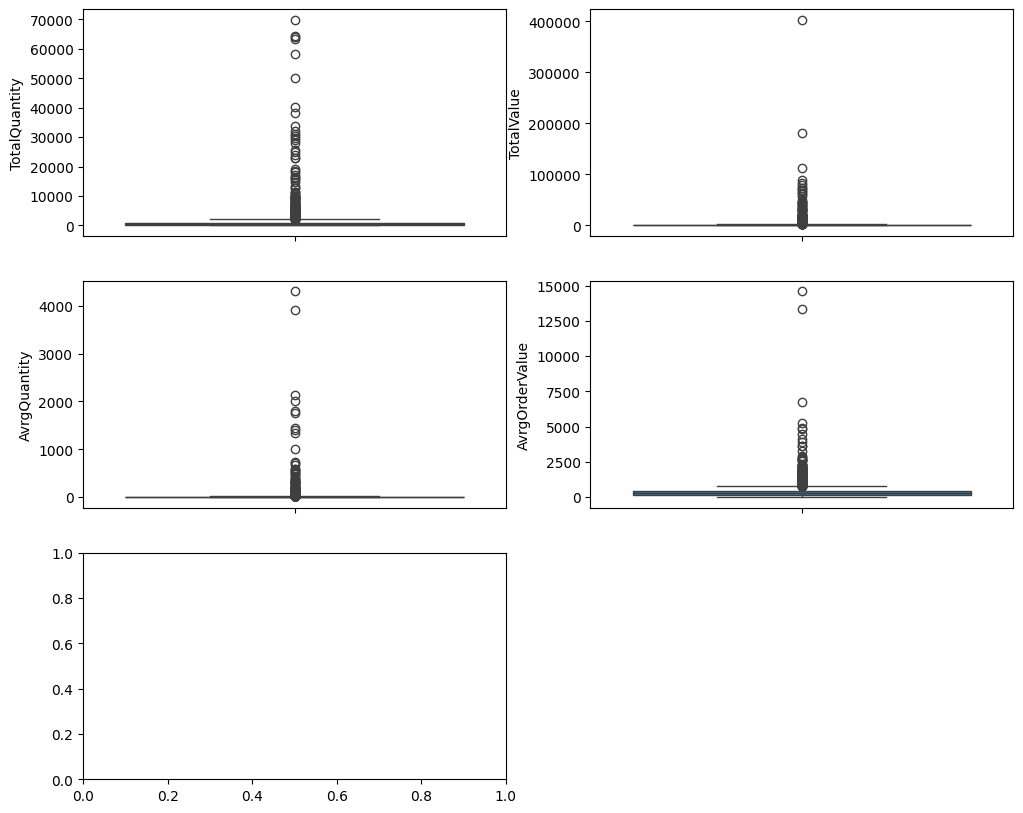

In [13]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))

sns.boxplot(data=cust['TotalQuantity'], ax=ax[0, 0]) 
sns.boxplot(data=cust['TotalValue'], ax=ax[0, 1]) 
sns.boxplot(data=cust['AvrgQuantity'], ax=ax[1, 0]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[1, 1]) 
#sns.boxplot(data=cust['TotalOrders'], ax=ax[2, 0]) 

# Remove the empty subplot
fig.delaxes(ax[2, 1])

plt.show()

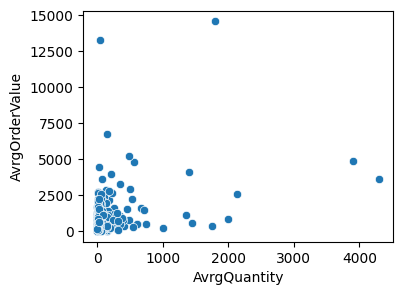

In [14]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust, x='AvrgQuantity', y='AvrgOrderValue')
plt.show()

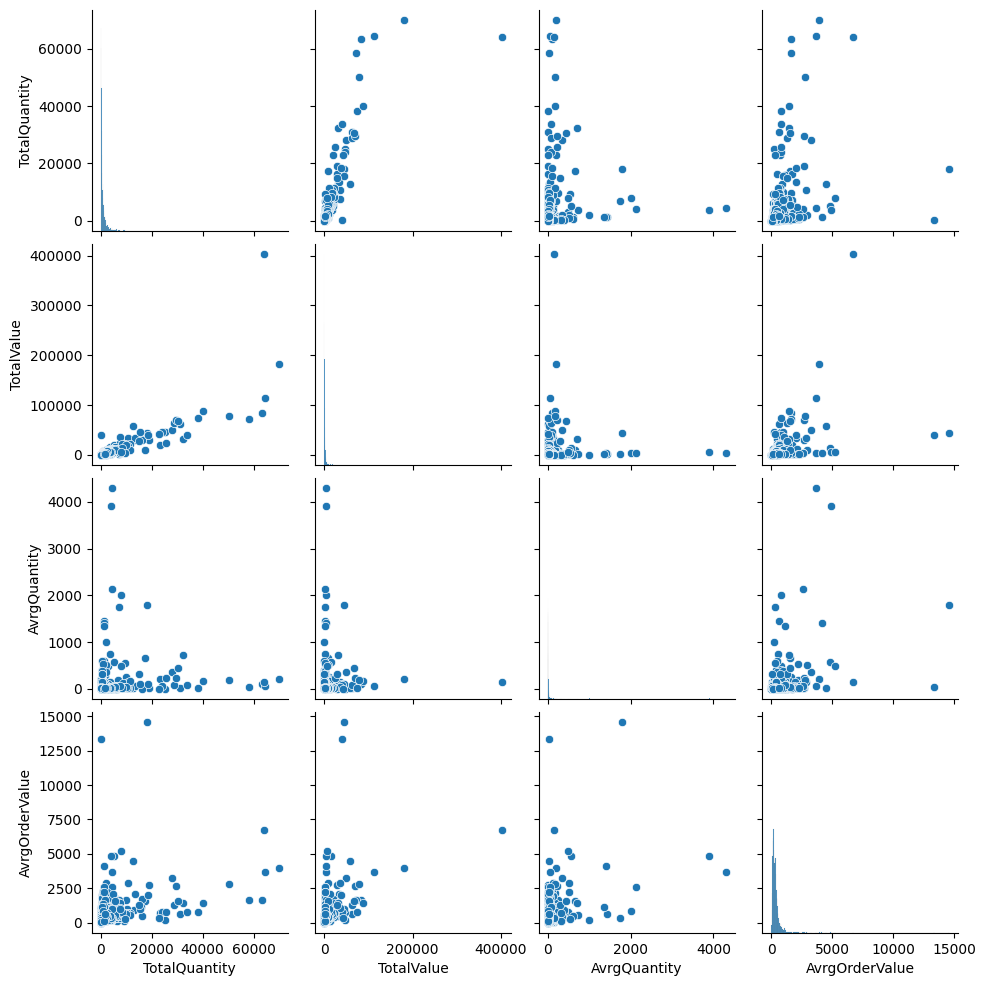

In [15]:
sns.pairplot(cust)

# Scaling data

*temp note from a linkedin article*

Normalization rescales your data to have values between 0 and 1, while standardization rescales your data to have a mean of 0 and a standard deviation of 1. You can use various methods to normalize or standardize your data, such as min-max scaling, z-score scaling, or log transformation.

has also more helpful info:
https://www.linkedin.com/advice/0/how-do-you-clean-your-data-before-clustering-skills-data-analysis#:~:text=Since%20clustering%20algorithms%20are%20sensitive,a%20standard%20deviation%20of%201.

also this very good: https://developers.google.com/machine-learning/data-prep/transform/normalization#:~:text=Z%2Dscore%20is%20a%20variation,extreme%20that%20you%20need%20clipping.

## MinMaxScaler

Normalization:** in this case, the values are transformed in such a way that the final values will be in the range [0,1].
$$z = \frac{x-min(x)}{(max(x)-min(x))}$$

MinMaxScaler can be more sensitive to outliers because the scale is heavily influenced by the extreme maximum and minimum values, so most probably is not the preferred way for this case.

In [16]:
# Creating an instance of the class MinMaxScaler normalizer
normalizer = MinMaxScaler()

In [17]:
normalizer.fit(cust)

MinMaxScaler()

In [18]:
# applying the transformation
cust_norm = normalizer.transform(cust)

In [19]:
cust_norm

array([[1.82072829e-02, 1.16964025e-02, 2.64712724e-03, 2.92192375e-02],
       [3.58000343e-01, 1.14045259e-01, 1.13282159e-03, 1.51091456e-02],
       [2.09941119e-02, 1.00147322e-02, 1.49337055e-03, 5.52213575e-02],
       ...,
       [1.45772595e-03, 3.71019729e-04, 1.76320074e-03, 5.03021487e-03],
       [1.93505974e-02, 5.01903871e-03, 2.25633868e-04, 8.48715997e-03],
       [2.26519179e-02, 4.72955361e-03, 5.19190509e-03, 4.34574659e-02]])

In [20]:
cust_norm = pd.DataFrame(cust_norm, columns = cust.columns, index=cust.index)
cust_norm.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
CustomerID,,,,
12747,0.018207,0.011696,0.002647,0.029219
12748,0.358000,0.114045,0.001133,0.015109
12749,0.020994,0.010015,0.001493,0.055221
12820,0.010304,0.002320,0.002615,0.015886
12821,0.000986,0.000223,0.002482,0.006155


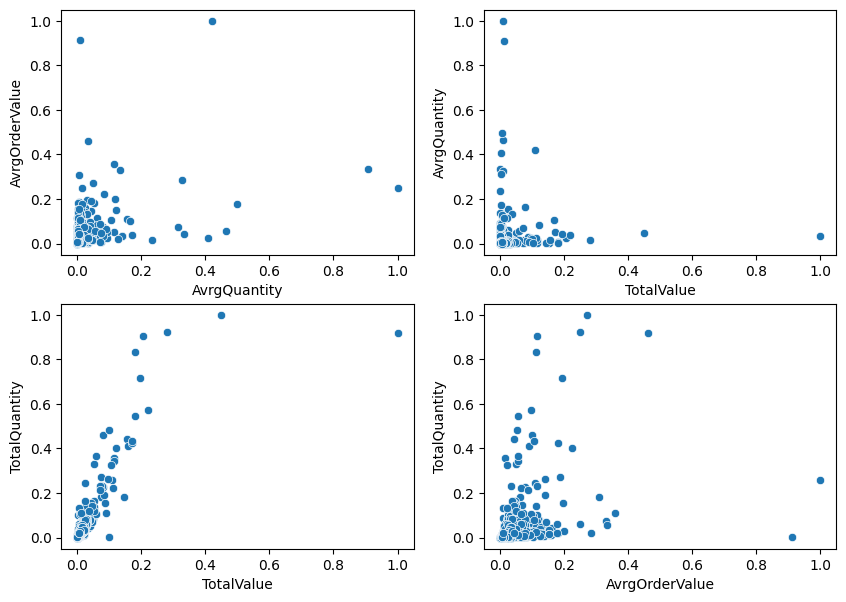

In [21]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

sns.scatterplot(data=cust_norm, x='AvrgQuantity', y='AvrgOrderValue', ax=ax[0, 0])
sns.scatterplot(data=cust_norm, x='TotalValue', y='AvrgQuantity', ax=ax[0, 1])
sns.scatterplot(data=cust_norm, x='TotalValue', y='TotalQuantity', ax=ax[1, 0])
sns.scatterplot(data=cust_norm, x='AvrgOrderValue', y='TotalQuantity', ax=ax[1, 1])

plt.show()

## StandardScaler

Standarization: the values are transfomed to end up with mean = 0 and std = 0.

$$z = \frac{(x-mean(x))}{\sigma}$$


In [22]:
scaler = StandardScaler()

In [23]:
scaler.fit(cust)

StandardScaler()

In [24]:
# applying the transformation
cust_standard = scaler.transform(cust)

In [25]:
cust_standard = pd.DataFrame(cust_standard, columns = cust.columns, index=cust.index)
cust_standard.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
CustomerID,,,,
12747,0.070640,0.315263,-0.081855,0.123325
12748,7.268276,5.024861,-0.133747,-0.308620
12749,0.129672,0.237881,-0.121392,0.919316
12820,-0.096768,-0.116205,-0.082971,-0.284833
12821,-0.294146,-0.212706,-0.087515,-0.582739


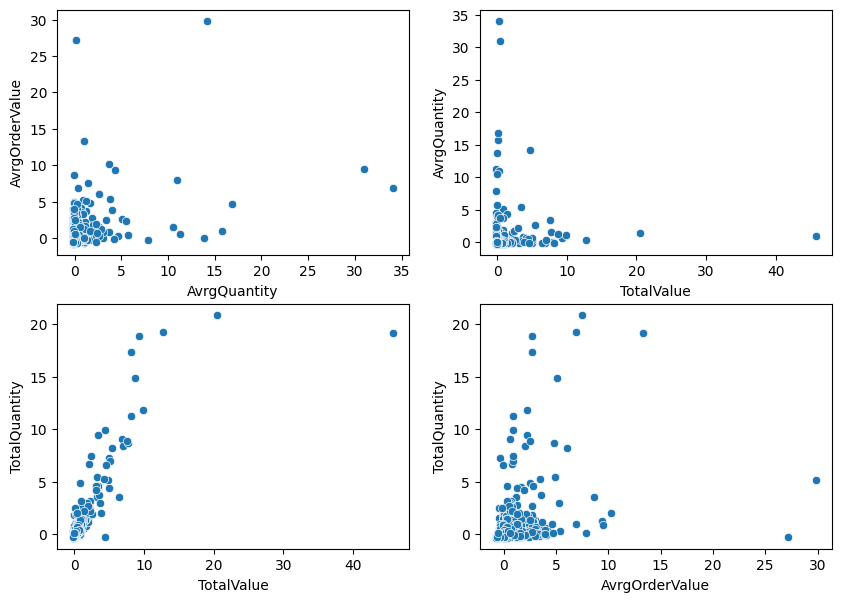

In [26]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10, 7))

sns.scatterplot(data=cust_standard, x='AvrgQuantity', y='AvrgOrderValue', ax=ax[0, 0])
sns.scatterplot(data=cust_standard, x='TotalValue', y='AvrgQuantity', ax=ax[0, 1])
sns.scatterplot(data=cust_standard, x='TotalValue', y='TotalQuantity', ax=ax[1, 0])
sns.scatterplot(data=cust_standard, x='AvrgOrderValue', y='TotalQuantity', ax=ax[1, 1])

plt.show()

# Building models

## K-Means clustering

After looking at my EDA, I conclude that K-Means will not be a good model for my dataset.

K-means can be quite sensitive to oultiers. Also, K-Means has an intrinsic preference for globular clusters and does not work very well on data comprised of arbitrarily shaped clusters, which in my case I don't have globular clusters.

## DBSCAN clustering

A density-based clustering algorithm.

DBSCAN tends to fall short of identifying clusters with non-uniform density.

### Elbow Method, for the optimal number of clusters

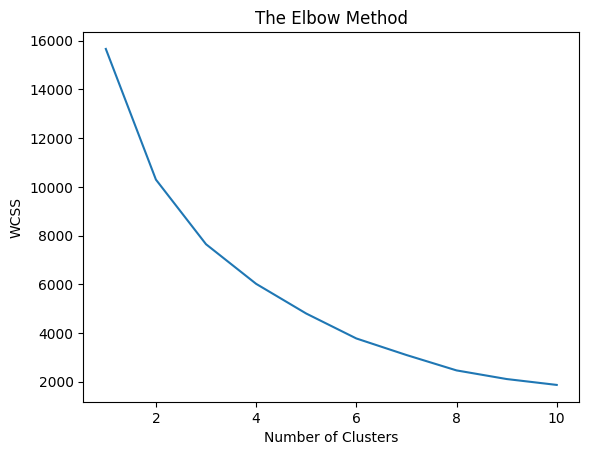

In [27]:
# Finding the optimal number of clusters
wcss = []

for i in range(1,11):
    kmeans = KMeans(n_clusters=i,
                    init='k-means++', max_iter=300, n_init=10)
    kmeans.fit(cust_standard)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

From the elbow method I am looking for the point on the plot where the decrease in WCSS starts to slow down and forms an "elbow" shape. Based on the plot, I will choose either 3 or 2 clusters.

## HDBSCAN

HDBSCAN is a more recently developed algorithm [3] built upon DBSCAN, which, unlike its predecessor, is capable of identifying clusters of varying density.

https://towardsdatascience.com/density-based-clustering-dbscan-vs-hdbscan-39e02af990c7

https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html

https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html

'HDBSCAN is much more robust in this sense: HDBSCAN can be seen as clustering over all possible values of eps and extracting the best clusters from all possible clusters. One immediate advantage is that HDBSCAN is scale-invariant.'

In [28]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

In [29]:
sns.boxplot(data=cust['TotalQuantity'], ax=ax[0, 0]) 
sns.boxplot(data=cust['TotalValue'], ax=ax[0, 1]) 
sns.boxplot(data=cust['AvrgQuantity'], ax=ax[1, 0]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[1, 1]) 

<Axes: xlabel='AvrgOrderValue', ylabel='TotalQuantity'>

In [30]:
cust[['TotalQuantity','AvrgOrderValue']]

,TotalQuantity,AvrgOrderValue
CustomerID,,
12747,1275,429.32
12748,25051,223.40
12749,1470,808.79
12820,722,234.74
12821,70,92.72
...,...,...
18280,45,180.75
18281,54,80.82
18282,103,76.31


In [31]:
cust_rst = cust.reset_index(drop=True)

In [32]:
cust_rst.head()

,TotalQuantity,TotalValue,AvrgQuantity,AvrgOrderValue
0,1275,4722.51,12.38,429.32
1,25051,46021.25,5.87,223.40
2,1470,4043.94,7.42,808.79
3,722,938.94,12.24,234.74
4,70,92.72,11.67,92.72


KeyError: (619, 0)

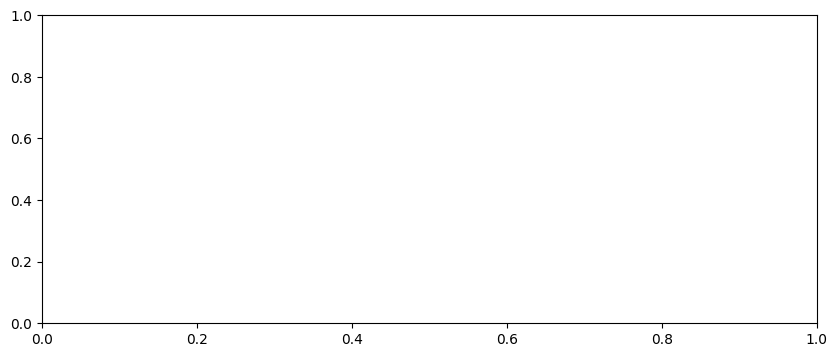

In [33]:
hdb = HDBSCAN().fit(cust_rst[['TotalQuantity','AvrgOrderValue']])
plot(cust_rst[['TotalQuantity','AvrgOrderValue']], hdb.labels_, hdb.probabilities_)

In [ ]:
# troubleshooting

In [ ]:
print("Input data shape:", cust[['TotalQuantity','AvrgOrderValue']].shape)
print("Cluster labels shape:", hdb.labels_.shape)


In [ ]:
print("Probabilities:", hdb.probabilities_)


In [ ]:
print("Indices causing KeyError:", [i for i, label in enumerate(hdb.labels_) if label not in np.unique(hdb.labels_)])


In [ ]:
print("Unique cluster labels:", np.unique(hdb.labels_))


In [ ]:
# with the hdbscan library

In [ ]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, gen_min_span_tree=True)
clusterer.fit(cust)

In [ ]:
clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)

In [ ]:
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)


In [ ]:
clusterer.condensed_tree_.plot()


In [ ]:
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())


In [ ]:
palette = sns.color_palette()
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
plt.scatter(cust.T[0], cust.T[1], c=cluster_colors, **plot_kwds)

# Test with outlier clipping

for this test I will use only two columns, and I will do outlier clipping by z-score to +-3σ (σ is the standard deviation).

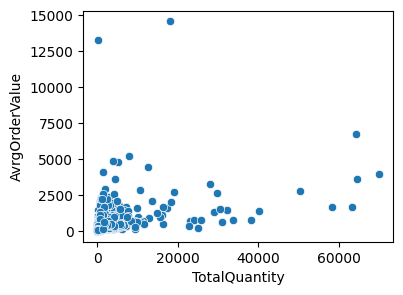

In [35]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust, x='TotalQuantity', y='AvrgOrderValue')
plt.show()

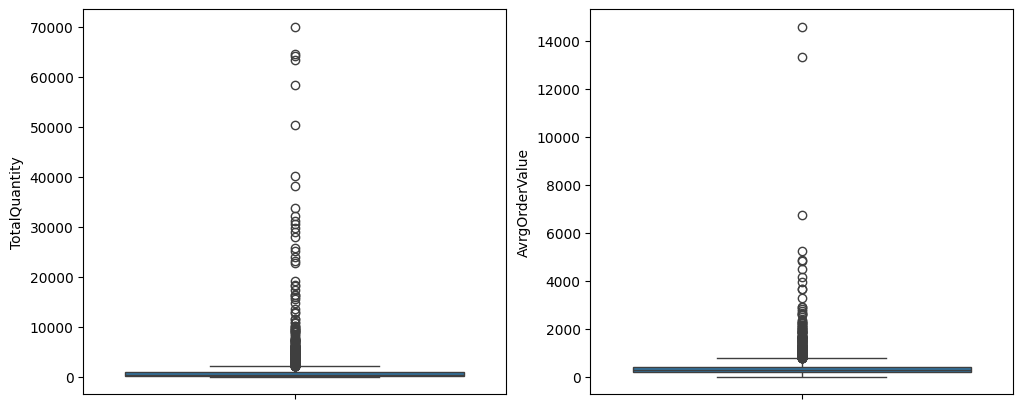

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

sns.boxplot(data=cust['TotalQuantity'], ax=ax[0]) 
sns.boxplot(data=cust['AvrgOrderValue'], ax=ax[1]) 

plt.show()

In [37]:
cust_fltrd = cust[['TotalQuantity','AvrgOrderValue']]

In [38]:
# 'TotalQuantity', I will find the Upper limit with the standard deviation method
# I don't have lower limit, cause everything start from 0
tq_UpperLimit = (cust_fltrd['TotalQuantity'].mean() + cust_fltrd['TotalQuantity'].std()*3).round(0).astype(int)
tq_UpperLimit

10953

In [39]:
# doing the same for the 'AvrgOrderValue'
aov_UpperLimit = (cust_fltrd['AvrgOrderValue'].mean() + cust_fltrd['AvrgOrderValue'].std()*3).round(2)
aov_UpperLimit

1800.89

In [40]:
cust_fltrd[cust_fltrd['TotalQuantity'] > tq_UpperLimit].shape[0] # 34 instances
cust_fltrd[cust_fltrd['AvrgOrderValue'] > aov_UpperLimit].shape[0] # 44 instances

44

In [41]:
# Clipping the data
cust_fltrd.loc[cust_fltrd['TotalQuantity'] > tq_UpperLimit , 'TotalQuantity'] = tq_UpperLimit
cust_fltrd.loc[cust_fltrd['AvrgOrderValue'] > aov_UpperLimit , 'AvrgOrderValue'] = aov_UpperLimit

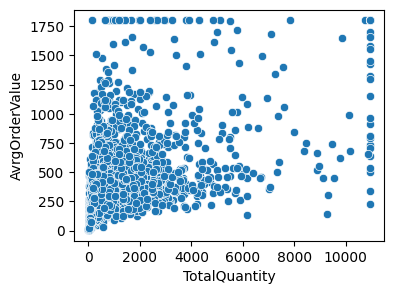

In [45]:
plt.figure(figsize=(4, 3)) 
sns.scatterplot(data=cust_fltrd, x='TotalQuantity', y='AvrgOrderValue')
plt.show()

# Clustering again the data with HDBSCAN

In [48]:
def plot(X, labels, probabilities=None, parameters=None, ground_truth=False, ax=None):
    if ax is None:
        _, ax = plt.subplots(figsize=(10, 4))
    labels = labels if labels is not None else np.ones(X.shape[0])
    probabilities = probabilities if probabilities is not None else np.ones(X.shape[0])
    # Black removed and is used for noise instead.
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    # The probability of a point belonging to its labeled cluster determines
    # the size of its marker
    proba_map = {idx: probabilities[idx] for idx in range(len(labels))}
    for k, col in zip(unique_labels, colors):
        if k == -1:
            # Black used for noise.
            col = [0, 0, 0, 1]

        class_index = np.where(labels == k)[0]
        for ci in class_index:
            ax.plot(
                X[ci, 0],
                X[ci, 1],
                "x" if k == -1 else "o",
                markerfacecolor=tuple(col),
                markeredgecolor="k",
                markersize=4 if k == -1 else 1 + 5 * proba_map[ci],
            )
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    preamble = "True" if ground_truth else "Estimated"
    title = f"{preamble} number of clusters: {n_clusters_}"
    if parameters is not None:
        parameters_str = ", ".join(f"{k}={v}" for k, v in parameters.items())
        title += f" | {parameters_str}"
    ax.set_title(title)
    plt.tight_layout()

KeyError: (81, 0)

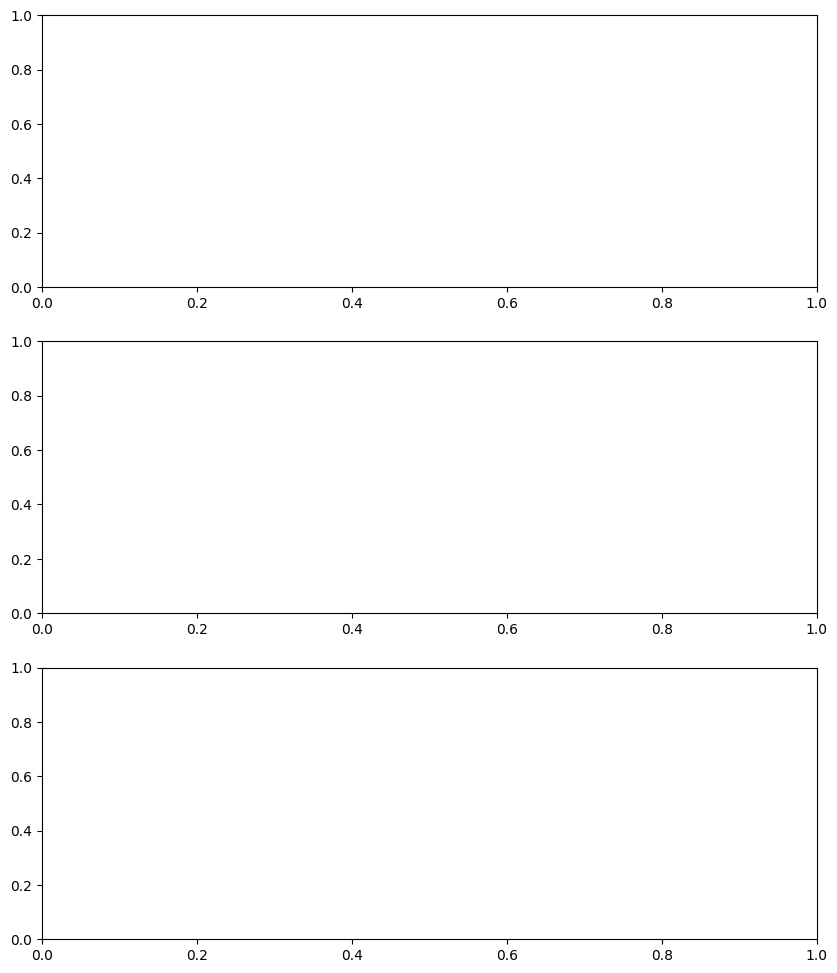

In [50]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
dbs = DBSCAN(eps=0.3)
for idx, scale in enumerate([1, 0.5, 3]):
    dbs.fit(cust_fltrd * scale)
    plot(cust_fltrd * scale, dbs.labels_, parameters={"scale": scale, "eps": 0.3}, ax=axes[idx])

KeyError: (73, 0)

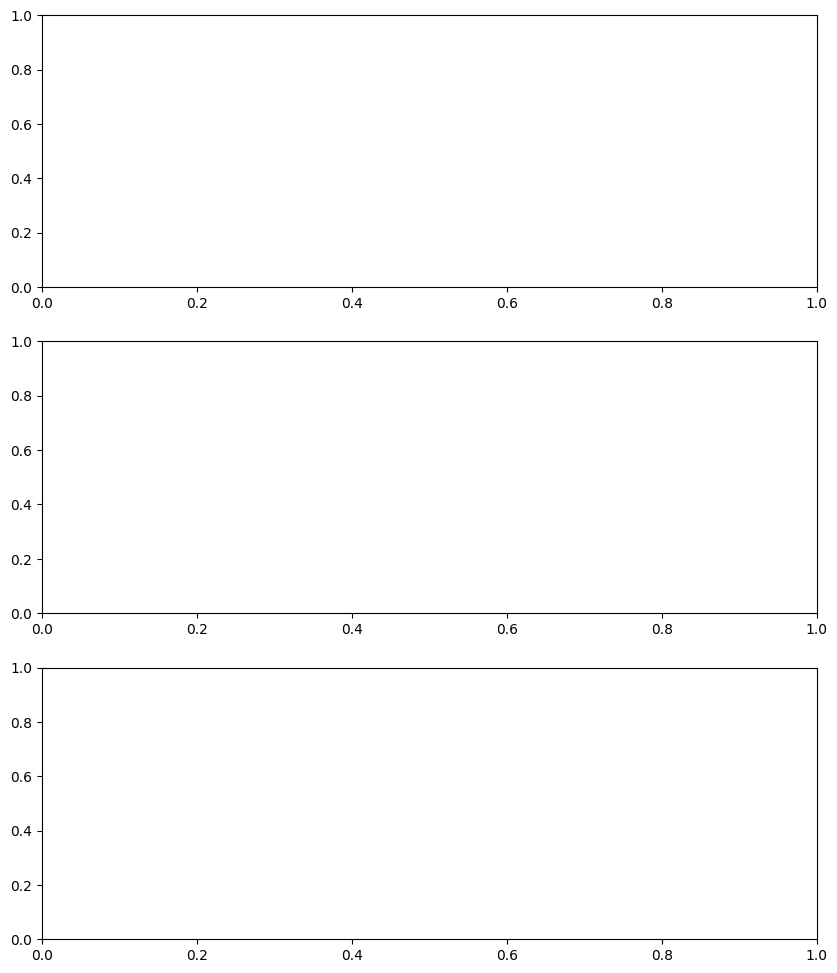

In [52]:
fig, axes = plt.subplots(3, 1, figsize=(10, 12))
hdb = HDBSCAN()
for idx, scale in enumerate([1, 0.5, 3]):
    hdb.fit(cust_fltrd * scale)
    plot(
        cust_fltrd * scale,
        hdb.labels_,
        hdb.probabilities_,
        ax=axes[idx],
        parameters={"scale": scale},
    )